DSSM Training

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [22]:
query = pd.read_csv("~/data/queries_train_indices.csv", header = None)
display(query)
query.isnull().sum()

,0,1
0,121352,1924 2363
1,634306,29570 321 193 198
2,920825,131 8242 1880 36968
3,510633,4711 38 31
4,737889,39755 99
...,...,...
808726,633855,752 703 2420 321
808727,1059728,6398 36572 136
808728,210839,1087 22
808729,908165,4 685 45818 233


0        0
1    15181
dtype: int64

In [2]:
def sparse_to_dense(idx, vocab_len):
    index_tensor = torch.LongTensor([idx])
    value_tensor = torch.Tensor([1]*len(idx))
    dense_tensor = torch.sparse.FloatTensor(index_tensor, value_tensor, torch.Size([vocab_len,])).to_dense()
    return dense_tensor

In [1]:
# test case:
top_dict = {1:[11,12,13,14], 2:[21,22,23,24]}
rating_dict = {1:{11:3,12:2,13:1}, 2:{21:2,23:1}}
query_test_dict = {1:[0,5,2], 2:[1,3,4]}
passage_dict = {11:[0,1,2,3,4], 12:[0,3,3,4], 13:[0,1], 14:[1,1,3],21:[1,2,1], 22:[0,2,5], 23:[1,2,2], 24:[0,0,5]}
result_dict = {1:{11:0.9, 12: 0, 13:0.5, 14:0.1}, 2:{21:0.3, 22: 0.6, 23:0.9, 24:0}}

In [28]:
import math
def get_ndcg_precision_rr(true_dict, test_dict, rank):
    sorted_result = sorted(test_dict.items(), key=lambda x: (x[1], [-1,1][random.randrange(2)]), reverse=True)
    original_rank = rank
    rank = min(rank, len(sorted_result))
    cumulative_gain = 0
    ideal_dict = {}
    num_positive = 0
    rr = float("NaN")
    for i in range(len(sorted_result)):
        pid = sorted_result[i][0]
        if pid in true_dict:
            rr = 1 / (i + 1)
            break
    for i in range(rank):
        pid = sorted_result[i][0]
        if pid in true_dict:
            num_positive += 1
    sorted_result = sorted(test_dict.items(), key=lambda x: x[1], reverse=True)
    for i in range(rank):
        pid = sorted_result[i][0]
        relevance = 0
        if pid in true_dict:
            relevance = true_dict[pid]
        ideal_dict[pid] = relevance
        discounted_gain = relevance / math.log2(2 + i)
        cumulative_gain += discounted_gain
    sorted_ideal = sorted(ideal_dict.items(), key=lambda x: x[1], reverse=True)
    ideal_gain = 0
    for i in range(rank):
        relevance = sorted_ideal[i][1]
        discounted_gain = relevance / math.log2(2 + i)
        ideal_gain += discounted_gain
    ndcg = 0
    if ideal_gain != 0:
         ndcg = cumulative_gain / ideal_gain
    return ndcg, num_positive / original_rank, rr

In [29]:
import random
result_dict = {1:10, 2:9, 3:8, 4:7, 5:6, 6:5}
rating_dict = {1:3, 2:2, 3:3, 5:1, 6:2, 7:3, 8:2}
get_ndcg_precision_rr(rating_dict, result_dict, 6)

(0.9608081943360617, 0.8333333333333334, 1.0)

In [71]:
import torch
torch.cosine_similarity(torch.FloatTensor([0,1,0]).unsqueeze(0),torch.FloatTensor([1,0,0]).unsqueeze(0))

tensor([0.])

In [4]:
import sys
import os
import torch
sys.path.insert(0, '/home/jianx/search-exposure/')
from load_data import obj_reader
from load_data import obj_writer

CURRENT_GPU = 0
if not os.path.exists(GPU_ROOT):
    obj_writer([0,0,0,0], GPU_ROOT)

In [31]:
def select_device():
    argmin = -1
    if not torch.cuda.is_available():
        device = torch.device("cpu")
    else:
        gpu_usage_list = obj_reader(GPU_ROOT)
        min = 100000
        argmin = 0
        for i, count in enumerate(gpu_usage_list):
            if count < min:
                argmin = i
                min = count
        gpu_usage_list[argmin] += 1
        print(gpu_usage_list)
        device = torch.device("cuda:" + str(argmin))
        obj_writer(gpu_usage_list, GPU_ROOT)
    return device,argmin

def cleanup_gpu_list():
    gpu_usage_list = obj_reader(GPU_ROOT)
    gpu_usage_list[CURRENT_GPU] -=1
    obj_writer(gpu_usage_list, GPU_ROOT)
device,CURRENT_GPU = select_device()
print(CURRENT_GPU)
print(torch.cuda.get_device_name(device))

[4, 3, 3, 3]
0
Tesla P100-PCIE-16GB


In [29]:
cleanup_gpu_list()




def evaluate_results(results, qrels):
    mrr = 0
    ncg = 0
    ndcg = 0
    for qid, docs in results.items():
        if qid not in qrels:
            continue
        qrels_q = qrels[qid]
        gains = [qrels_q.get(doc[0], 0) for doc in docs]
        ideal_gains = sorted(list(qrels_q.values()), reverse=True)
        max_metric_pos_disc = min(len(gains), 10)
        max_metric_pos = min(len(gains), 100 if task_docs else 1000)
        ideal_max_metric_pos_disc = min(len(ideal_gains), 10)
        ideal_max_metric_pos = min(len(ideal_gains), 100 if task_docs else 1000)
        cg = sum([gains[i] for i in range(max_metric_pos)])
        dcg = sum([gains[i] / math.log2(i + 2) for i in range(max_metric_pos_disc)])
        ideal_cg = sum([ideal_gains[i] for i in range(ideal_max_metric_pos)])
        ideal_dcg = sum([ideal_gains[i] / math.log2(i + 2) for i in range(ideal_max_metric_pos_disc)])
        ncg += cg / ideal_cg if ideal_cg > 0 else 0
        ndcg += dcg / ideal_dcg if ideal_dcg > 0 else 0
        try:
            if task_docs:
                mrr += 1 / ([1 if gain > 1 else 0 for gain in gains].index(1) + 1)
            else:
                mrr += 1 / ([min(gain, 1) for gain in gains].index(1) + 1)
        except Exception:
            pass
    mrr /= len(qrels)
    ncg /= len(qrels)
    ndcg /= len(qrels)
    return mrr, ncg, ndcg

In [1]:
import sys
sys.path.insert(0, '/home/jianx/search-exposure/forward_ranker/')
import torch
from train import generate_sparse
from load_data import obj_reader
import network
from annoy import AnnoyIndex

In [2]:
MODEL_PATH = "/home/jianx/data/results/100_1000_1000_0.001_256_10.model"
DEVICE = torch.device("cuda:1")
EMBED_SIZE = 256

In [3]:
NET = network.DSSM(embed_size=EMBED_SIZE)
NET.load_state_dict(torch.load(MODEL_PATH))
NET.to(DEVICE)
NET.eval()

DSSM(
  (model): Sequential(
    (0): Linear(in_features=100000, out_features=64, bias=True)
    (1): ReLU()
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ReLU()
    (10): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=64, out_features=256, bias=True)
  )
)

In [ ]:
EMBEDDING_PATH = "/home/jianx/data/results/passage_embeddings.dict"
passage_embeddings = obj_reader(EMBEDDING_PATH)

In [ ]:
print(len(passage_embeddings[0]))

In [4]:
QUERY_TEST_DICT = obj_reader("/home/jianx/data/queries_test.dict")
PASSAGE_DICT = obj_reader("/home/jianx/data/passages.dict")

In [5]:
RATING_DICT = obj_reader("/home/jianx/data/rel_scores.dict")

### Brute Force Full Retrieval

In [12]:
QIDS = list(RATING_DICT.keys())
QUERY_EMBEDDINGS = []
for qid in QIDS:
    q_seq = QUERY_TEST_DICT[qid]
    QUERY_EMBEDDINGS.append(NET(generate_sparse(q_seq).to(DEVICE)).detach())
QUERY_EMBEDDING_TENSOR = torch.stack(QUERY_EMBEDDINGS, dim=0).unsqueeze(dim=1)
QUERY_EMBEDDING_TENSOR.shape

torch.Size([43, 1, 256])

In [14]:
print(QIDS[0])

19335


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [46]:
empty = torch.empty([3,0])
print(empty)
q = torch.FloatTensor([[1,1,1],[2,2,2],[3,3,3]])
print(q)
p = torch.FloatTensor([[4,4,4],[2,2,2],[3,3,3]])
r = torch.cat([empty,q],dim=1)
r = torch.cat([r,p],dim=1)
print(r)
print(r[0].data)

tensor([], size=(3, 0))
tensor([[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.]])
tensor([[1., 1., 1., 4., 4., 4.],
        [2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3.]])
tensor(1.)


In [29]:
pids = [1,2,3,4,5,6,7,8,9,10]
pids_2d = []
slice_idx = 0
while slice_idx + 3 < len(pids):
    pid_batch = pids[slice_idx:(slice_idx + 3)]
    slice_idx += 3
    pids_2d.append(pid_batch)
pids_2d.append(pids[slice_idx:])
print(pids_2d)

[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10]]


In [49]:
from datetime import datetime, timezone, timedelta
print("[{}] {}".format(datetime.now(timezone(timedelta(hours=-4))).strftime("%b %d, %H:%M:%S"), "hello"), flush=True)

[Jul 09, 04:26:21] hello
100000000


In [6]:
import random
test_dict = {"one":1, "two":2, "three":3, "four":4}
dict(random.sample(list(test_dict.items()), 2))

NameError: name 'take' is not defined

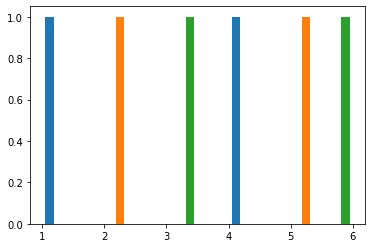

In [14]:
import numpy as np
import matplotlib.pyplot as plt
test_array = np.array([[1,2,3], [4,5,6]])
test_array.flatten()
plt.hist(test_array)
plt.show()

In [ ]:
import sys
sys.path.insert(0, '/home/jianx/search-exposure/forward_ranker/')
import torch
from train import generate_sparse
from load_data import obj_reader
import network
from annoy import AnnoyIndex
import matplotlib.pyplot as plt

In [ ]:
rankings = obj_reader("/home/jianx/data/train_data/test_rankings.np")
print(rankings)
plt.hist(rankings[rankings!=0].flatten(),bins=100)
plt.title("Distribution of All Document Ranks (Total 1000 Documents)")
plt.show()

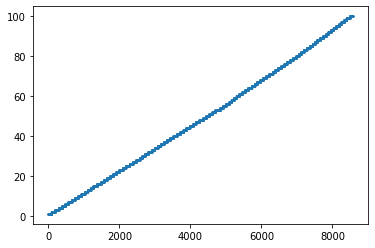

In [6]:
plt.scatter(range(len(rankings[rankings!=0].flatten())), sorted(rankings[rankings!=0].flatten()),s=1)
plt.show()

In [ ]:
rankings = obj_reader("/home/jianx/data/train_data/test_rankings.np")
print(rankings)
plt.hist(rankings[rankings!=0].flatten(),bins=100)
plt.show()

In [25]:
mean_ranking = np.mean(rankings[rankings!=0])
print(mean_ranking)

48.70746791131855


In [27]:
all_means = []
all_nonzero = []
for i in range(rankings.shape[0]):
    temp_list = rankings[i,:]
    temp_list = temp_list[temp_list != 0]
    all_nonzero.append(len(temp_list))
    if len(temp_list) != 0:
        all_means.append(np.mean(temp_list))
print(all_means, all_nonzero)

[82.0, 79.0, 56.0, 66.0, 53.714285714285715, 30.5, 54.888888888888886, 76.0, 53.142857142857146, 39.68518518518518, 46.63636363636363, 63.0, 85.66666666666667, 71.0, 61.77777777777778, 57.25, 49.9375, 68.33333333333333, 72.33333333333333, 55.55555555555556, 50.07692307692308, 78.0, 48.666666666666664, 54.08695652173913, 42.142857142857146, 27.6, 18.5, 57.51851851851852, 54.916666666666664, 53.0, 47.31578947368421, 48.0, 52.666666666666664, 60.72727272727273, 44.0, 41.333333333333336, 42.0, 29.0, 63.0, 47.333333333333336, 49.8, 49.0, 42.8, 68.125, 59.714285714285715, 41.375, 48.0, 78.4, 32.38461538461539, 74.5, 60.0, 57.6, 32.333333333333336, 60.0, 29.0, 54.42857142857143, 44.15384615384615, 65.0, 49.72727272727273, 97.0, 64.14285714285714, 28.0, 56.0, 41.142857142857146, 38.76086956521739, 47.5, 49.42857142857143, 57.0, 44.1, 62.9, 48.59375, 54.333333333333336, 39.54347826086956, 65.88888888888889, 85.66666666666667, 57.5, 40.5, 51.785714285714285, 51.93877551020408, 65.25, 48.0, 42.68

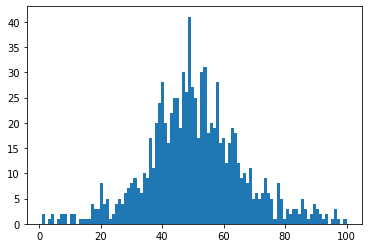

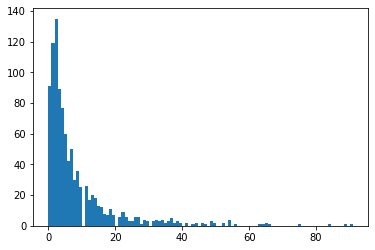

In [29]:
plt.hist(all_means, bins=100)
plt.show()
plt.hist(all_nonzero, bins=100)
plt.show()

In [35]:
count_zero = 0
for i, c in enumerate(all_nonzero):
    if c == 0:
        count_zero += 1
print(count_zero)

91


In [38]:
with open("/home/jianx/data/temp.txt","w+") as f:
    f.write("")
for i in range(10):
    with open("/home/jianx/data/temp.txt","a") as f:
        f.write(str(i)+"\n")

/home/jianx/data/train_data/256_20000_100_100_training.csv


In [5]:
import torch
a = torch.tensor([1,2,3,4,5])
b = torch.tensor([4,3,2,1,0])
a.argsort(descending=True).tolist()

[4, 3, 2, 1, 0]

In [12]:
import numpy as np
dict(zip(range(5),np.random.rand(5,5).tolist()))
np.random.rand(256)

array([0.4161164 , 0.43947958, 0.72923258, 0.69588524, 0.08347633,
       0.68541983, 0.95858567, 0.97423596, 0.59845477, 0.09634946,
       0.81475968, 0.29749467, 0.62576508, 0.25443689, 0.94463678,
       0.34501376, 0.60031886, 0.28762873, 0.30334989, 0.69118863,
       0.03632864, 0.20695645, 0.25677788, 0.06461229, 0.92856228,
       0.90408629, 0.29429594, 0.02460186, 0.54437542, 0.8790665 ,
       0.54677063, 0.76914395, 0.70347354, 0.94019034, 0.45235504,
       0.37337442, 0.10606974, 0.57995701, 0.64904716, 0.14109894,
       0.37940028, 0.3341507 , 0.59834319, 0.59639086, 0.84937768,
       0.32121573, 0.04166376, 0.94188534, 0.69863139, 0.44763642,
       0.52389008, 0.4568322 , 0.49954346, 0.52846967, 0.3871767 ,
       0.60781766, 0.02386038, 0.82633897, 0.131487  , 0.91848134,
       0.27439564, 0.36784816, 0.10759383, 0.87391971, 0.4439074 ,
       0.67382921, 0.09697783, 0.69934966, 0.43347846, 0.31265942,
       0.19929125, 0.42029016, 0.61771595, 0.89509429, 0.11222